<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Build a Generative Adversarial Network model using WML Training Service</b></font></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/scikit-learn/hand-written-digits-recognition/images/numbers_banner-04.png" width="600" alt="Icon"></td>
   </tr>
</table>

This notebook demonstrates how to build a `Generative Adversarial Network (GAN)` Model in Keras and deploy the model in the `Watson Machine Learning (WML)` repository. 

GANs were proposed by Ian J. Goodfellow et al., in 2014. GANs are unsupervised learning models based on Deep Learning. A GAN consists of two models, the `Generative` model and the `Adversarial` model.

The `Generative` model can be thought of as analogous to a team of counterfeiters trying  to  produce  fake  currency  and  use  it  without  detection.  On the other hand, the  `Discriminative` model is analogous to the police trying to detect the counterfeit currency[1](#cite). 

Competition in this game drives both teams to improve their methods until the counterfeits are indistinguishable from the genuine articles. You can check the details of GAN <a href="https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf" target="_blank" rel="noopener noreferrer">here</a>.

In this notebook, `Fashion MNIST` data set is used to generate counterfeit images. `Fashion MNIST` consists of a `training` set of `60,000` images and a `test` set of `10,000` images. 

Each image is a `28x28` grayscale image associated with a label from 10 classes. You can find about `Fashion MNIST` <a href="https://github.com/zalandoresearch/fashion-mnist" target="_blank" rel="noopener noreferrer">here</a>.

This notebook covers the following items: 

- Obtain data.
- Persist training definitions in the Watson Machine Learning repository.
- Train a GAN model.
- Deploy the trained GAN model.
- Score the trained model.

Some familiarity with Python is helpful. This notebook is compatible with Python 3.6 and uses <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/environments-parent.html" target="_blank" rel="noopener no referrer">Watson Studio environments.</a>


## Learning goals

In this notebook, you will learn how to:

-  Set up Watson Machine Learning training service to train a GAN model written in Keras.
-  Save the trained GAN model in the Watson Machine Learning repository.
-  Deploy the trained GAN model online and score it.


## Contents

1. [Set up the environment](#setup)
2. [Explore data](#data)
3. [Create training definitions](#model)
4. [Train the GAN model](#train)
5. [Save the GAN model](#save)
6. [Deploy the GAN model](#deploy)
7. [Score the GAN model](#score)
8. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before proceeding to the following sections, please perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>).
-  Create a <a href="https://cloud.ibm.com/catalog/services/cloud-object-storage" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a> instance (a lite plan is offered and information about how to order storage can be found <a href="https://cloud.ibm.com/docs/services/cloud-object-storage/basics?topic=cloud-object-storage-provision#order-storage" target="_blank" rel="noopener no referrer">here</a>). <br/>**Note: When using Watson Studio, you already have a COS instance associated with the project you are running the notebook in.**
- Create new credentials with HMAC: 
    - Go to your COS dashboard.
    - In the **Service credentials** tab, click **New Credential (+)**.
    - Add the inline configuration parameter: {"HMAC":true}, click **Add**. (For more information, see <a href="https://cloud.ibm.com/docs/services/cloud-object-storage/hmac?topic=cloud-object-storage-hmac#using-hmac-credentials" target="_blank" rel="noopener no referrer">HMAC</a>.)

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "-------",
            "secret_access_key": "-------"
       }
    ```

In this section, you will learn how to:

- [1.1 Set up the Cloud Object Storage (COS) service](#cos)
- [1.2 Download Fashion MNIST data files and upload them to the COS buckets](#mnist)
- [1.3 Set up the Watson Machine Learning (WML) instance](#wml)

### 1.1 Set up the Cloud Object Storage (COS) service <a id="cos"></a>

Install the IBM boto package. This package allows Python developers to manage Cloud Object Storage (COS).

**Tip:** If `ibm_boto3` is not preinstalled in your environment, run the following command to install it: 

In [ ]:
# Run the command if ibm_boto3 is not installed.
!pip install --upgrade ibm-cos-sdk

In [2]:
# Import the boto module.
import ibm_boto3
from ibm_botocore.client import Config

Enter your COS credentials in the following cell. 

You can find these credentials in your COS instance dashboard under the **Service credentials** tab.

**Note:** The HMAC key described in [set up the environment](#setup) is included in these credentials.

In [3]:
cos_credentials = {
    'apikey': '***',
    'cos_hmac_keys': {
        'access_key_id': '***',
        'secret_access_key': '***'
    },
    'endpoints': 'https://cos-service.bluemix.net/endpoints',
    'iam_apikey_description': 'Auto generated apikey during resource-key operation for Instance',
    'iam_apikey_name': 'auto-generated-apikey',
    'iam_role_crn': 'crn:v1:bluemix:public:iam::::serviceRole:Writer',
    'iam_serviceid_crn': 'crn:v1:bluemix:public:iam-identity:',
    'resource_instance_id': 'crn:v1:bluemix:public:cloud-object-storage:global:'
}

Define the endpoint.

To do this, go to the **Endpoint** tab in the COS instance's dashboard to get the endpoint information, then copy-and-paste it in the cell below:

In [4]:
# Define endpoint information.
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

You also need the IBM Cloud authorization endpoint to be able to create COS resource object.

In [5]:
# Define the authorization endpoint.
auth_endpoint = 'https://iam.bluemix.net/oidc/token'

Create a Boto resource to be able to write data to COS.

In [6]:
# Create a COS resource.
cos = ibm_boto3.resource(
    's3',
     ibm_api_key_id=cos_credentials['apikey'],
     ibm_service_instance_id=cos_credentials['resource_instance_id'],
     ibm_auth_endpoint=auth_endpoint,
     config=Config(signature_version='oauth'),
     endpoint_url=service_endpoint
)

Create two buckets, which you will use to store training data and training results.

**Note:** The bucket names must be unique.

In [7]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = ['gan-training-data-' + bucket_uid, 'gan-training-results-' + bucket_uid]

for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "gan-training-data-4069b46a-fdfb-4637-a98a-2ec0f3ef4b24"...
Creating bucket "gan-training-results-4069b46a-fdfb-4637-a98a-2ec0f3ef4b24"...


Now, you should have 2 buckets.

In [8]:
# Display a list of created buckets.
print([x.name for x in list(cos.buckets.all()) if x.name.startswith('gan-training')])

['gan-training-data-4069b46a-fdfb-4637-a98a-2ec0f3ef4b24', 'gan-training-results-4069b46a-fdfb-4637-a98a-2ec0f3ef4b24']


### 1.2 Download the Fashion MNIST training data files and upload them to the COS buckets <a id="mnist"></a>

Download the training data and upload it to the 'training-data' bucket.

First, create a list of links for the training data set. Although there are 4 files in the Fashion MNIST dataset, `training images`, `labels of the training images`, `test images`, and `labels for test images`, only the `training images` will be used in this notebook.

This is because of the nature of unsupervised learning of `GANs`. The goal of `GANs` is to generate fake images as close as possible to the real images. Hence, `labels` and `test images` are not required.

**Tip**: The Fashion MNIST data set that you are downloading from the link in the following cell are basically the same one in Keras that will be explored in section [2. Explore data](#data).

In [9]:
# Create a list of links.
data_links = [
    'https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz?raw=true' # Training set images
]

The code in the next cell uploads files from links to your COS.

In [10]:
# Upload files from the links to COS
from urllib.request import urlopen

bucket_obj = cos.Bucket(buckets[0])

for data_link in data_links:
    filename = data_link.split('/')[-1].split('?')[0]
    print('Uploading data {}...'.format(filename))
    with urlopen(data_link) as data:
        bucket_obj.upload_fileobj(data, filename)
        print('{} is uploaded.'.format(filename))

Uploading data train-images-idx3-ubyte.gz...
train-images-idx3-ubyte.gz is uploaded.


Have a look at the list of the created buckets and each bucket's content.

In [11]:
for bucket_name in buckets:
    print(bucket_name)
    bucket_obj = cos.Bucket(bucket_name)
    for obj in bucket_obj.objects.all():
        print('\tFile: {}, {:4.2f} kB'.format(obj.key, obj.size/1024))

gan-training-data-4069b46a-fdfb-4637-a98a-2ec0f3ef4b24
	File: train-images-idx3-ubyte.gz, 25802.62 kB
gan-training-results-4069b46a-fdfb-4637-a98a-2ec0f3ef4b24


You are done with COS and ready to train your model!

### 1.3 Set up the Watson Machine Learning (WML) instance <a id="wml"></a>

Import the modules you need to set up your WML instance.

**Hint:** You may also need to install `wget` using the following command: `!pip install --upgrade wget`

In [ ]:
!pip install --upgrade wget

In [13]:
import json
import os
import wget

Authenticate the Watson Machine Learning (WML) service on the IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the <a href="https://console.bluemix.net/docs/services/service_credentials.html#service_credentials" target="_blank" rel="noopener noreferrer">Service credentials</a> tab of the service instance that you created on the IBM Cloud. 
If there are no credentials listed for your instance in **Service credentials**, click **New credential (+)** and enter the information required to generate new authentication information. 

**Action**: Enter your WML service instance credentials in the following cell.

In [15]:
wml_credentials = {
    'username': '***',
    'password': '***',
    'instance_id': '***',
    'url': 'https://ibm-watson-ml.mybluemix.net'
}

#### Install the `watson-machine-learning-client` package from pypi.

**Note:** `watson-machine-learning-client` documentation can be found <a href="http://wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener noreferrer">here</a>.

In [15]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [ ]:
!pip install --upgrade watson-machine-learning-client

#### Import the `watson-machine-learning-client` module and authenticate the service instance.

In [17]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

client = WatsonMachineLearningAPIClient(wml_credentials)

## 2. Explore data <a id="data"></a>

In this section, you will plot some images in the `Fashion MNIST` data set.

First, import the required modules.

In [18]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np

Load the data set. `X_train` and the `training images` mentioned in section [1.2 Download the Fashion MNIST training data files and upload them to the COS buckets](#mnist) are the same.

In [19]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [20]:
print('Train data set dimension: {}'.format(X_train.shape))
print('Test data set dimension: {}'.format(X_test.shape))
print('Train label dimension: {}'.format(y_train.shape))
print('Test label dimension: {}'.format(y_test.shape))

Train data set dimension: (60000, 28, 28)
Test data set dimension: (10000, 28, 28)
Train label dimension: (60000,)
Test label dimension: (10000,)


According to `Zalando Research`, there are 10 classes in the data set.

The following are the class names:
1. T-shirt/top
2. Trouser
3. Pullover
4. Dress
5. Coat
6. Sandal
7. Shirt
8. Sneaker
9. Bag
10. Ankle boot

In [21]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot_images(X_train, y_train, class_names, row_num, col_num, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    for i in range(row_num * col_num):
        plt.subplot(row_num, col_num, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_train[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[y_train[i]])

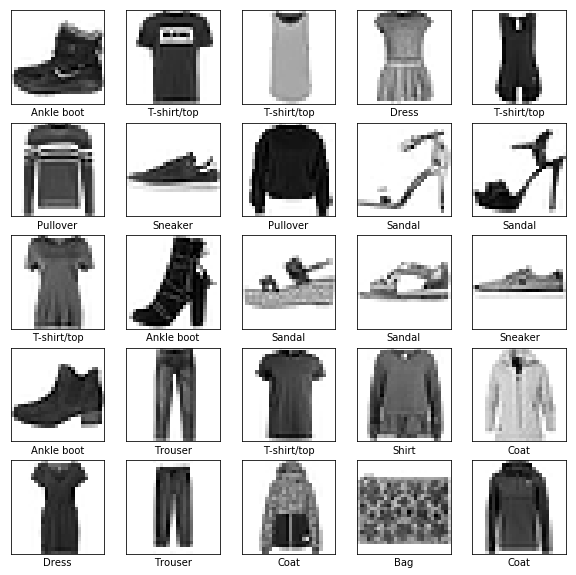

In [22]:
plot_images(X_train, y_train, class_names, 5, 5)

<a id="model"></a>
## 3. Create the training definitions

In this section, you will:

- [3.1 Create the training definition metadata](#prep)
- [3.2 Get the sample model definition content files from Git](#get)
- [3.3 Store the training definitions in the WML repository](#store)



### 3.1 Create the training definition metadata<a id="prep"></a>

In [23]:
model_definition_metadata = {
    client.repository.DefinitionMetaNames.NAME: 'gan_training',
    client.repository.DefinitionMetaNames.DESCRIPTION: 'gan_training-definition',
    client.repository.DefinitionMetaNames.AUTHOR_NAME: 'Jihyoung Kim',
    client.repository.DefinitionMetaNames.FRAMEWORK_NAME: 'tensorflow',
    client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: '1.13',
    client.repository.DefinitionMetaNames.RUNTIME_NAME: 'python',
    client.repository.DefinitionMetaNames.RUNTIME_VERSION: '3.6',
    client.repository.DefinitionMetaNames.EXECUTION_COMMAND: 'python3 gan_fashion_mnist.py --epochs 30000'
}

### 3.2 Get the sample model definition content file from Git (after legal checklist approval) <a id="get"></a>

In [24]:
filename = 'gan_fashion_mnist.zip'

if not os.path.isfile(filename):
    filename = wget.download('https://github.com/IBMDataScience/sample-notebooks/raw/master/Files/gan_fashion_mnist.zip')
    
print(filename)

gan_fashion_mnist.zip


In [25]:
!ls

gan_fashion_mnist.zip


### 3.3 Store the training definition in the WML repository<a id="store"></a>

In [26]:
definition_details = client.repository.store_definition(filename, model_definition_metadata)

In [27]:
definition_uid = client.repository.get_definition_uid(definition_details)

In [28]:
# Display the training definition uid.
print(definition_uid)

a17caf43-9eb3-43e2-b9a4-d8a2b74c7e5b


## 4. Train the GAN model<a id="train"></a>

In this section, you will learn how to:
- [4.1 Configure training metadata](#meta)
- [4.2 Train the model in the background](#backg)
- [4.3 Monitor the training log](#log)
- [4.4 Cancel the training run](#cancel)


### 4.1 Configure training metadata<a id="meta"></a>

- `TRAINING_DATA_REFERENCE` - references the uploaded training data.
- `TRAINING_RESULTS_REFERENCE` - location where the trained model will be saved.

**Note**: Your COS credentials are referenced in this code.


In [29]:
# Configure the training metadata for the TRAINING_DATA_REFERENCE and TRAINING_RESULTS_REFERENCE.
training_configuration_metadata = {
    client.training.ConfigurationMetaNames.NAME: 'gan_training', 
    client.training.ConfigurationMetaNames.AUTHOR_NAME: 'Jihyoung Kim',              
    client.training.ConfigurationMetaNames.DESCRIPTION: 'gan_training_definition',
    client.training.ConfigurationMetaNames.COMPUTE_CONFIGURATION: {'name': 'v100'},
    client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCE: {
        'connection': {
            'endpoint_url': service_endpoint,
            'access_key_id': cos_credentials['cos_hmac_keys']['access_key_id'],
            'secret_access_key': cos_credentials['cos_hmac_keys']['secret_access_key']
        },
        'source': {
            'bucket': buckets[0]
        },
        'type': 's3'
    },
    client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE: {
        'connection': {
            'endpoint_url': service_endpoint,
            'access_key_id': cos_credentials['cos_hmac_keys']['access_key_id'],
            'secret_access_key': cos_credentials['cos_hmac_keys']['secret_access_key']
        },
        'target': {
            'bucket': buckets[1]
        },
        'type': 's3'
    }
}

### 4.2 Train the model in the background<a id="backg"></a>

To run the training in the **background**, please set the optional parameter `asynchronous` as `True` (or remove it). In this case, the parameter has been removed. 

**Note:** To run the training in **active** mode, please set the optional parameter `asynchronous` as `False`.

In [30]:
training_run_details = client.training.run(definition_uid, training_configuration_metadata)

In [31]:
training_run_guid_async = client.training.get_run_uid(training_run_details)

Check the status of the training run by calling the method the next cell:

In [32]:
# Get training run status.
status = client.training.get_status(training_run_guid_async)
print(json.dumps(status, indent=2))

{
  "state": "pending",
  "submitted_at": "2019-10-21T12:37:28.427Z",
  "message": "training-RyOtjwTWg: Submitted",
  "metrics": [],
  "current_at": "2019-10-21T12:37:30.968Z"
}


### 4.3  Monitor the training log<a id="log"></a>

Run the cell below to monitor the training log.

In [33]:
from time import time

In [34]:
ts = time()
client.training.monitor_logs(training_run_guid_async)
te = time()



####################################################

Log monitor started for training run: model-bp53xi4q

####################################################


training-RyOtjwTWg: Training with training/test data at:

training-RyOtjwTWg:   DATA_DIR: /mnt/data/gan-training-data-4069b46a-fdfb-4637-a98a-2ec0f3ef4b24

training-RyOtjwTWg:   MODEL_DIR: /job/model-code

training-RyOtjwTWg:   TRAINING_JOB: 

training-RyOtjwTWg:   TRAINING_COMMAND: python3 gan_fashion_mnist.py --epochs 30000

training-RyOtjwTWg: Storing trained model at:

training-RyOtjwTWg:   RESULT_DIR: /mnt/results/gan-training-results-4069b46a-fdfb-4637-a98a-2ec0f3ef4b24/training-RyOtjwTWg

training-RyOtjwTWg: Mon Oct 21 12:37:42 UTC 2019: Running Tensorflow job

training-RyOtjwTWg: Collecting idx2numpy

training-RyOtjwTWg:   Downloading https://files.pythonhosted.org/packages/23/6b/abab4652eb249f432c62431907c8de32bdcedb5abdf869ff86653efff981/idx2numpy-1.2.2.tar.gz

training-RyOtjwTWg: Requirement already satisfied: nu

In [35]:
print('Time elapsed: {:.2f} min'.format((te - ts) / 60))

Time elapsed: 8.83 min


### 4.4 Cancel the training run<a id="cancel"></a>

You can cancel the training run by calling the method below.

<a id="save"></a>
## 5. Save the GAN model

#### Call this method to the save the trained model in the WML repository.

In [36]:
# Save model to WML repository.
saved_model_details = client.repository.store_model(
    training_run_guid_async, {'name': 'Fashion MNIST GAN model'}
)

In [37]:
# Display location of saved model.
print('Url: {}'.format(client.repository.get_model_url(saved_model_details)))

Url: https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/published_models/ee208b67-c766-4d5a-a3fd-3cb8c39ca3d2


**Tip:** Run the code below to extract the stored model uid from the dictionary.

In [38]:
# Get and display model uid.
model_uid = client.repository.get_model_uid(saved_model_details)
print('Saved model uid: {}'.format(model_uid))

Saved model uid: ee208b67-c766-4d5a-a3fd-3cb8c39ca3d2


#### List the stored models.

#### Delete the training run and its results.

Run the code in the cell below to delete train runs and results:

## 6. Deploy the GAN model<a id="deploy"></a>

Run the code in the following cell to deploy the stored model as a web service (online):

In [39]:
# Create online deployment.
deployment_details = client.deployments.create(model_uid, 'Fashion MNIST GAN model deployment')



#######################################################################################

Synchronous deployment creation for uid: 'ee208b67-c766-4d5a-a3fd-3cb8c39ca3d2' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='1067d3db-d48c-4743-a83c-c207793209b7'
------------------------------------------------------------------------------------------------




## 7. Score the GAN model<a id="score"></a>

Now, extract the url endpoint and scoring_url which will be used to send scoring requests.

Since `GANs` are `unsupervised` models, the results of scoring (prediction) are the `generated (fake) images` from the `generator`.

In [ ]:
#  Extract endpoint url and display it.
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

For scoring, 25 images will be generated. Hence, generate a 25x100 matrix with random float numbers between 0 and 1.

In [41]:
col_num = 5
row_num = 5
payload = np.random.normal(0, 1, (row_num * col_num, 100))
payload.shape

(25, 100)

Send the data to the `scoring_url` to generate `fake images`.

In [42]:
pred = client.deployments.score(scoring_url, {'values': payload.tolist()})

In [43]:
generated_images = 0.5 * np.array(pred['values']) + 0.5

You can see the generated `fake` images by the `generator` in the below cell.

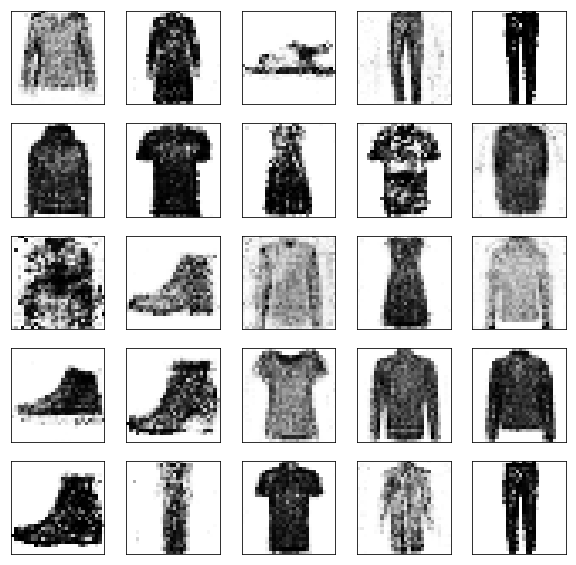

In [44]:
plt.figure(figsize=(10, 10))
for i in range(row_num * col_num):
    plt.subplot(row_num, col_num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(generated_images[i, :, :, 0], cmap=plt.cm.binary)

<a id="summary"></a>
## 8. Summary and next steps     

You successfully completed this notebook! 
 
You have learned how to:
- Train a `Generative Adversarial Network (GAN)` model in Keras using the `Watson Machine Learning (WML)` training service.
- Deploy the `Generative Adversarial Network (GAN)` model in the `Watson Machine Learning (WML)` repository.
 
Check out our <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener noreferrer">Online Documentation</a> for a <a href="https://dataplatform.ibm.com/docs/content/analyze-data/ml-python-mnist-tutorial.html" target="_blank" rel="noopener noreferrer">tutorial</a> and more samples, documentation, how-tos, and blog posts. 

### Citations <a id="cite"></a>
1. *Ian J. Goodfellow et al.*, **Generative Adversarial Nets**, Advances in neural information processing systems, 2014.
2. *Zalando Research*, **Fashion MNIST**.

### Authors

**Jihyoung Kim**, Ph.D., is a Data Scientist at IBM who strives to make data science easy for everyone through Watson Studio.

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>